In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

## Optimization Loop

In this tutorial, we'll construct an optimization loop demonstrating how we can use MPoL to synthesize a basic image. We'll continue with the dataset described in the [Gridding and Diagnostic Images](gridder.html) tutorial.

### Gridding recap
Let's set up the gridder and coordinates as before

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpol import gridding, coordinates, precomposed, losses, utils
from astropy.utils.data import download_file
from IPython.display import SVG, display

In [4]:
# load the mock dataset of the ALMA logo
fname = download_file(
    "https://zenodo.org/record/4498439/files/logo_cube.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data_re = d["data_re"][chan]
data_im = -d["data_im"][
    chan
]  # we're converting from CASA convention to regular TMS convention by complex conjugating the visibilities

In [5]:
# define the image dimensions, as in the previous tutorial
coords = coordinates.GridCoords(cell_size=0.005, npix=800)
gridder = gridding.Gridder(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

# Note that we needed to do the gridding with "uniform" in order to
# propagate the uncertainties needed for RML correctly.
gridder.grid_visibilities(weighting="uniform")

### The PyTorch dataset

Now we will export the gridded visibilities to a PyTorch dataset to use in the imaging loop. This is essentially the same representation stored in the gridder, but with PyTorch tensors instead of numpy arrays. To keep things simple in this tutorial, we are only using a single channel. But you could just as easily export a multi-channel dataset.

In [6]:
dset = gridder.to_pytorch_dataset()
print("this dataset has {:} channel".format(dset.nchan))

this dataset has 1 channel


### Building an image model

MPoL provides "modules" to build and optimize complex imaging workflows, not dissimilar to how a deep neural network might be constructed.We've bundled the most common modules for imaging together in a [SimpleNet](../api.html#mpol.precomposed.SimpleNet) meta-module, which we'll use here.

This diagram shows how the primitive modules, like [BaseCube](../api.html#mpol.images.BaseCube), [ImageCube](../api.html#mpol.images.ImageCube), etc... are connected together to form [SimpleNet](../api.html#mpol.precomposed.SimpleNet). In this workflow, the pixel values of the [BaseCube](../api.html#mpol.images.BaseCube) are the core model parameters representing the image. More information about all of these components is available in the [API documentation](../api.html).

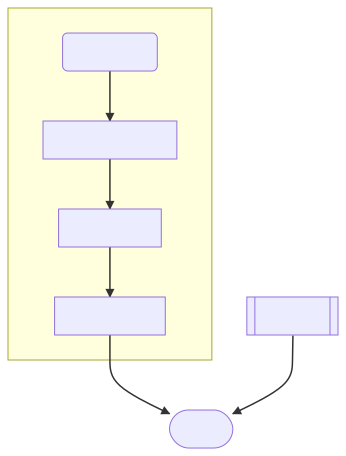

In [7]:
display(SVG(filename="../_static/mmd/build/SimpleNet.svg"))

It isn't necessary to construct a meta-module to do RML imaging with MPoL, though it often helps organize your code. If we so desired, we could connect the individual modules together ourselves ourselves [(following the SimpleNet source code as an example)](../_modules/mpol/precomposed.html#SimpleNet) and swap in/out modules as we saw fit.

We then initialize SimpleNet with the relevant information

In [8]:
rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)

### Breaking down the training loop

Our goal for the rest of the tutorial is to set up a loop that will

1. evaluate the current model against a loss function
2. calculate the gradients of the loss w.r.t. the model
3. advance the model parameters in the direction to minimize the loss function

We'll start by creating the optimizer

In [9]:
optimizer = torch.optim.SGD(rml.parameters(), lr=500.0)

The role of the optimizer is to advance the parameters (in this case, the pixel values of the [BaseCube](../api.html#mpol.images.BaseCube)) using the gradient of the loss function with respect to those parameters. PyTorch has many different [optimizers](https://pytorch.org/docs/stable/optim.html#module-torch.optim) available, and it is worthwhile to try out some of the different ones. Stochastic Gradient Descent (SGD) is one of the simplest, so we’ll start here. The `lr` parameter is the 'learning rate,' or how ambitious the optimizer should be in taking descent steps. Tuning this requires a bit of trial and error: you want the learning rate to be small enough so that the algorithm doesn’t diverge but large enough so that the optimization completes in a reasonable amount of time.

### Loss functions
In the parlance of the machine learning community, one defines "loss" functions comparing models to data. For regularized maximum likelihood imaging, the most fundamental loss function we'll use is the [data likelihood](../api.html#mpol.losses.loss_fn) or the $\chi^2$ value comparing the model visibilities to the data visibilities. For this introductory tutorial, we'll use only the data likelihood loss function to start, but you should know that because imaging is an ill-defined inverse problem, this is not a sufficient constraint by itself. In later tutorials, we will apply regularization to narrow the set of possible images towards ones that we believe are more realistic. The [mpol.losses](../api.html#module-mpol.losses) module contains several loss functions currently popular in the literature, so you can experiment to see which best suits your application.

### Gradient descent

Let's walk through how we calculate a loss value and optimize the parameters. To start, let's [examine the parameters of the model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [10]:
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       ...,
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

These are the default values that were used to initialize the [BaseCube](../api.html#mpol.images.BaseCube) component of the [SimpleNet](../api.html#mpol.precomposed.SimpleNet).

For demonstration purposes, lets access and plot the base cube with matplotlib. In a normal workflow you probably won't need to do this, but to access the basecube in sky orientation, we do

In [11]:
bcube_pytorch = utils.packed_cube_to_sky_cube(rml.bcube.base_cube)

``bcube`` is still a PyTorch tensor, but matplotlib requires numpy arrays. To convert back, we need to first ["detach" the computational graph](https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor) from the PyTorch tensor (used to propagate gradients) and then call the numpy conversion routine.

In [12]:
bcube_numpy = bcube_pytorch.detach().numpy()
print(bcube_numpy.shape)

(1, 800, 800)


lastly, we remove the channel dimension to plot the 2D image using ``np.squeeze``

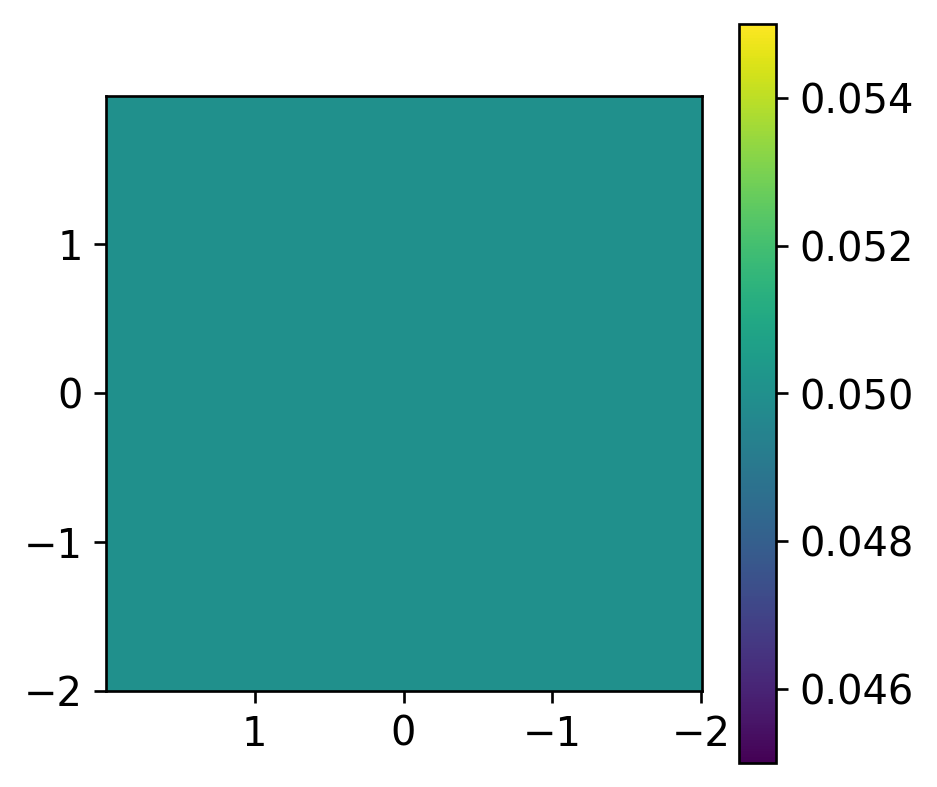

In [13]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(bcube_numpy),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.colorbar(im)

A blank image is not that exciting, but hopefully this demonstrates the state of the parameters at the start of optimization.

Because we'll want to compute a clean set of gradient values in a later step, we "zero out" any gradients attached to the tensor components so that they aren't counted twice.

In [14]:
rml.zero_grad()

Most modules in MPoL are designed to work in a "feed forward" manner, which means base parameters are processed through the network to predict model visibilites for comparison with data. We can calculate the full visibility cube corresponding to the current pixel values of the [BaseCube](../api.html#mpol.images.BaseCube)

In [15]:
vis = rml.forward()
print(vis)

tensor([[[ 1.1481e+01+0.0000e+00j,  7.1800e-03+2.8196e-05j,
          -7.1797e-03-5.6390e-05j,  ...,
           7.1791e-03-8.4581e-05j, -7.1797e-03+5.6390e-05j,
           7.1800e-03-2.8196e-05j],
         [ 7.1800e-03+2.8196e-05j,  4.4902e-06+3.5266e-08j,
          -4.4899e-06-5.2898e-08j,  ...,
           4.4899e-06-3.5264e-08j, -4.4902e-06+1.7633e-08j,
           4.4903e-06+4.9217e-19j],
         [-7.1797e-03-5.6390e-05j, -4.4899e-06-5.2898e-08j,
           4.4895e-06+7.0527e-08j,  ...,
          -4.4899e-06+1.7632e-08j,  4.4901e-06-6.4302e-19j,
          -4.4902e-06-1.7633e-08j],
         ...,
         [ 7.1791e-03-8.4581e-05j,  4.4899e-06-3.5264e-08j,
          -4.4899e-06+1.7632e-08j,  ...,
           4.4885e-06-1.0578e-07j, -4.4891e-06+8.8154e-08j,
           4.4895e-06-7.0526e-08j],
         [-7.1797e-03+5.6390e-05j, -4.4902e-06+1.7633e-08j,
           4.4901e-06+6.4011e-19j,  ...,
          -4.4891e-06+8.8154e-08j,  4.4895e-06-7.0527e-08j,
          -4.4899e-06+5.2898e-08j],
 

Of course, these aren't that exciting since they just reflect the constant value image.

But, exciting things are about to happen! We can calculate the loss between these model visibilities and the data

In [16]:
# calculate a loss
loss = losses.nll_gridded(vis, dset)
print(loss.item())

22.09555274683534


and then we can calculate the gradient of the loss function with respect to the parameters

In [17]:
loss.backward()

/opt/hostedtoolcache/Python/3.8.10/x64/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:219.)
  Variable._execution_engine.run_backward(


We can even visualize what the gradient of the [BaseCube](../api.html#mpol.images.BaseCube) looks like (using a similar ``.detach()`` call as before)

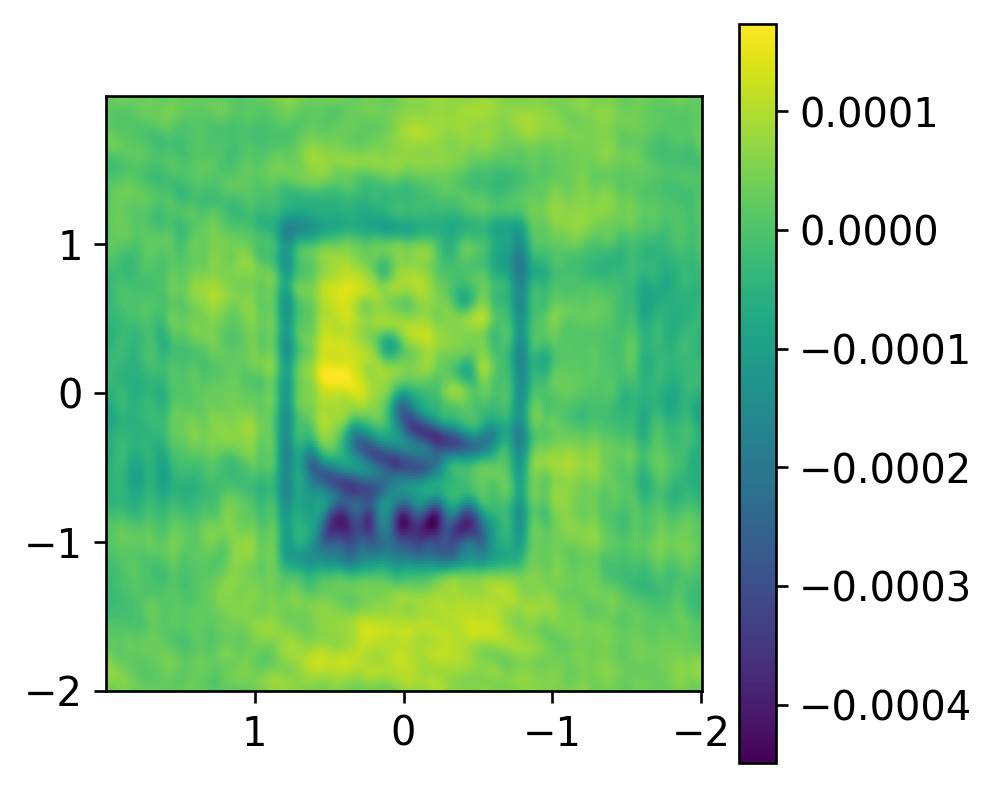

In [18]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(
        utils.packed_cube_to_sky_cube(rml.bcube.base_cube.grad).detach().numpy()
    ),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.colorbar(im)

The gradient image points in the direction of lower loss values. So the final step is to add the gradient image to the base image in order to advance base parameters in the direction of the minimum loss value. This process is called gradient descent, and can be extremely useful for optimizing large dimensional parameter spaces (like images). The optimizer carries out the addition of the gradient

In [19]:
optimizer.step()

We can see that the parameter values have changed

In [20]:
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[0.0925, 0.0923, 0.0917,  ..., 0.0915, 0.0921, 0.0925],
                       [0.0883, 0.0880, 0.0874,  ..., 0.0875, 0.0881, 0.0883],
                       [0.0842, 0.0839, 0.0832,  ..., 0.0837, 0.0841, 0.0842],
                       ...,
                       [0.1055, 0.1054, 0.1048,  ..., 0.1037, 0.1046, 0.1052],
                       [0.1011, 0.1010, 0.1004,  ..., 0.0996, 0.1004, 0.1009],
                       [0.0968, 0.0966, 0.0960,  ..., 0.0955, 0.0962, 0.0967]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

as has the base image

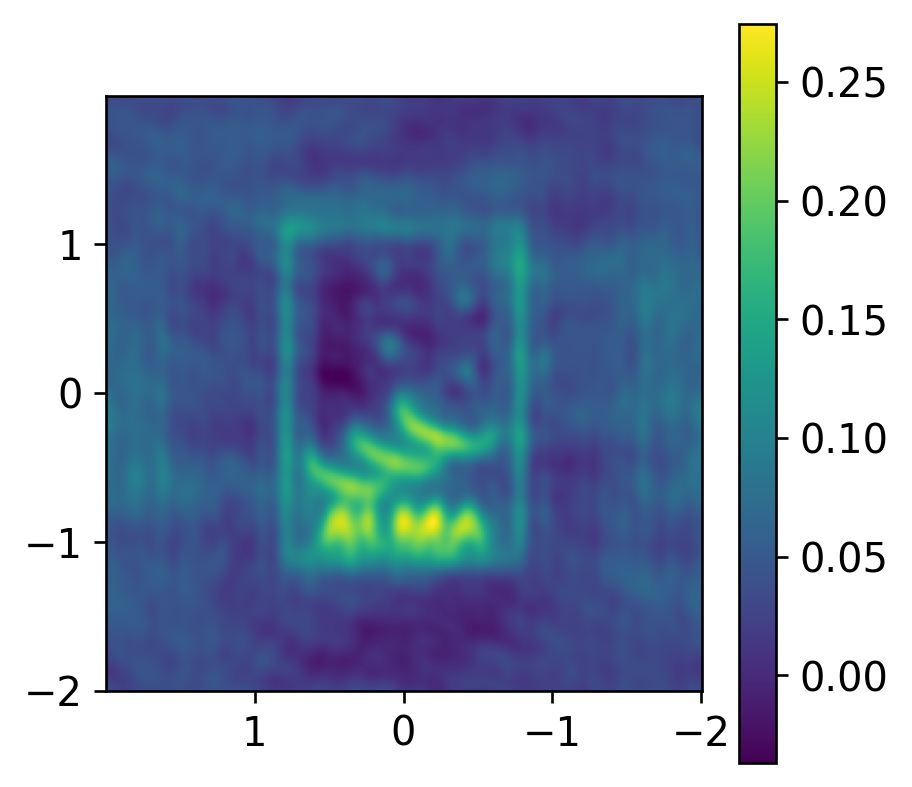

In [21]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube).detach().numpy()),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.colorbar(im)

### Iterating the training Loop

Now that we've covered how to use gradient descent to optimize a set of image parameters, let's wrap these steps into a training loop and iterate a few hundred times to converge to a final product.

In addition to the steps just outlined, we'll also track the loss values as we optimize.

In [22]:
%%time

loss_tracker = []

for i in range(300):
    rml.zero_grad()

    # get the predicted model
    vis = rml.forward()

    # calculate a loss
    loss = losses.nll_gridded(vis, dset)

    loss_tracker.append(loss.item())

    # calculate gradients of parameters
    loss.backward()

    # update the model parameters
    optimizer.step()

CPU times: user 1min 2s, sys: 7.59 s, total: 1min 10s
Wall time: 40 s


Text(0, 0.5, 'loss')

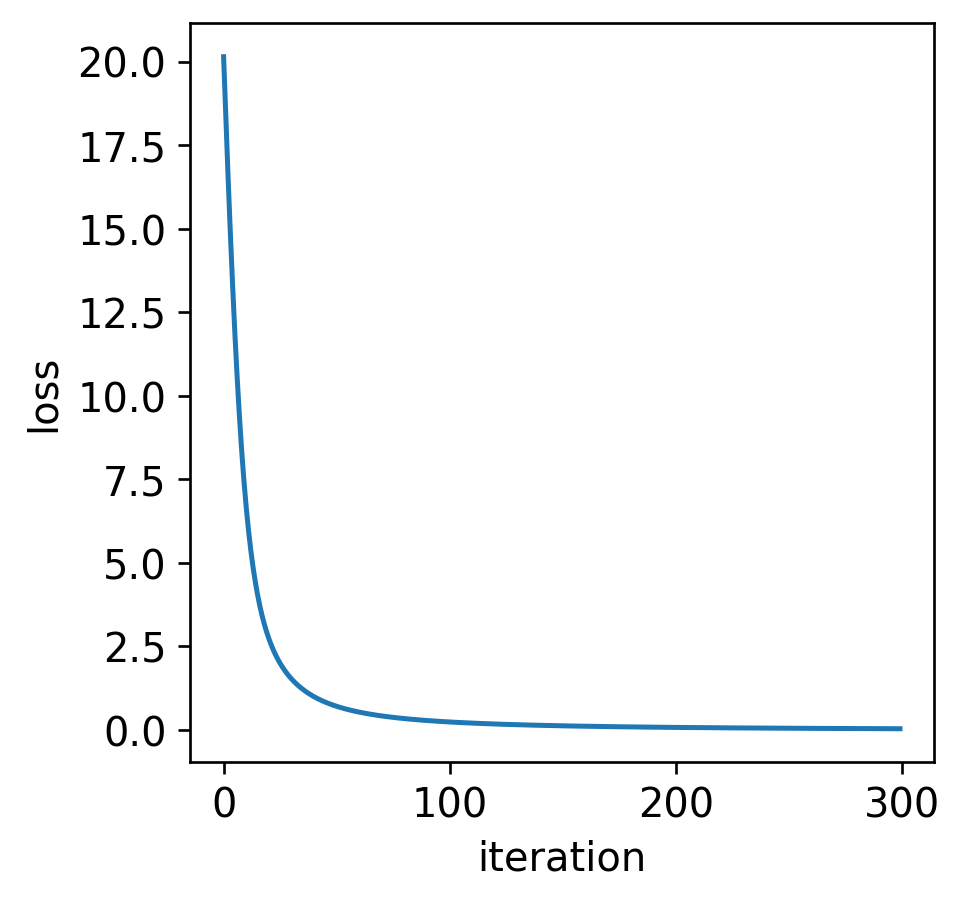

In [23]:
fig, ax = plt.subplots(nrows=1)
ax.plot(loss_tracker)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")

and we see that we've reasonably converged to a set of parameters without much further improvement in the loss value.

### Visualizing output

Let's visualize the final product. The bounds for `matplotlib.pyplot.imshow` are available in the `img_ext` parameter.

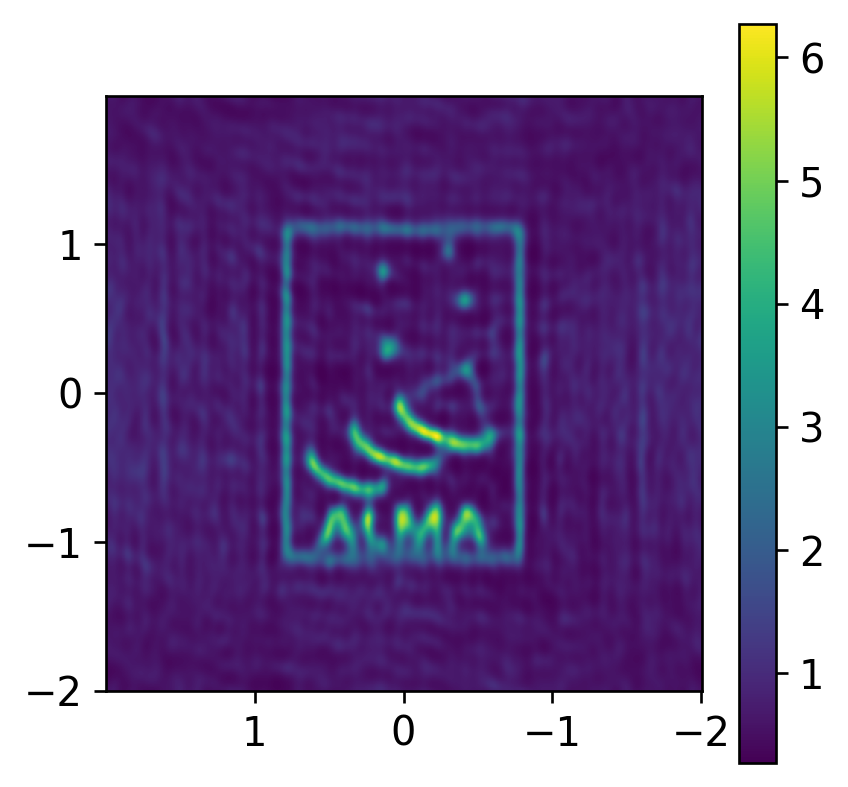

In [24]:
# let's see what one channel of the image looks like
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(rml.icube.sky_cube.detach().numpy()),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.colorbar(im)

### Wrapup

And there you have it, an image optimized to fit the data. Don't be fooled into thinking that minimal regularization (like we've done here with only the data likelihood) yields the most conservative image estimates, however! With this setup, we've done *some* regularization because the functional basis set we chose automatically enforced image positivity (see the [BaseCube](../api.html#mpol.images.BaseCube) documentation), but in truth we aren't too far off from the dirty image itself.

Though the dirty image is easy to produce and is in fact a maximal likelihood image (with no regularization), we would argue that it's far from a conservative image since it is generated by making some rather strong assumptions about the data---that unsampled spatial frequencies carry zero power. In future tutorials we'll examine how to set up additional regularizer terms that can yield more desireable image characteristics.

Hopefully this tutorial has demonstrated the core concepts of synthesizing an image with MPoL. If you have any questions about the process, please feel free to reach out and start a [GitHub discussion](https://github.com/MPoL-dev/MPoL/discussions). If you spot a bug or have an idea to improve these tutorials, please raise a [GitHub issue](https://github.com/MPoL-dev/MPoL/issues) or better yet [submit a pull request](file:///Users/ian/Documents/Research/Disks/RML/MPoL/docs/_build/html/developer-documentation.html).